##### Social Media Analytics
### Introduction to Text Mining
## Frequency Analysis
(c) Nuno Antonio 2019-2022 v1.02

### Initial setup

In [53]:
# Import packages
import csv
import re

import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer

In [54]:
ds = pd.read_parquet("fattoComments.parquet.snappy", engine="fastparquet")

In [55]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66340 entries, 0 to 66339
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   link     66340 non-null  object
 1   comment  66340 non-null  object
dtypes: object(2)
memory usage: 1.0+ MB


### Functions

In [56]:
# Text preprocessing
def textPreProcess(
    rawText,
    removeHTML=True,
    charsToRemove=r"\?|\.|\!|\;|\.|\"|\,|\(|\)|\&|\:|\-|\'s",
    removeNumbers=True,
    removeLineBreaks=False,
    specialCharsToRemove=r"[^\x00-\xfd]",
    convertToLower=True,
    removeConsecutiveSpaces=True,
):
    if type(rawText) != str:
        return rawText
    procText = rawText

    # Remove HTML
    if removeHTML:
        procText = BeautifulSoup(procText, "html.parser").get_text()

    # Remove punctuation and other special characters
    if len(charsToRemove) > 0:
        procText = re.sub(charsToRemove, " ", procText)

    # Remove numbers
    if removeNumbers:
        procText = re.sub(r"\d+", " ", procText)

    # Remove line breaks
    if removeLineBreaks:
        procText = procText.replace("\n", " ").replace("\r", "")

    # Remove special characters
    if len(specialCharsToRemove) > 0:
        procText = re.sub(specialCharsToRemove, " ", procText)

    # Normalize to lower case
    if convertToLower:
        procText = procText.lower()

    # Replace multiple consecutive spaces with just one space
    if removeConsecutiveSpaces:
        procText = re.sub(" +", " ", procText)

    return procText

In [57]:
# Tokenize words
def tokenize_words(words):
    if (type(words) != str) or (word_tokenize(words) == ""):
        return np.nan
    else:
        return word_tokenize(words)

In [58]:
# Stemm texts
def stemming(words):
    stemmed_word = [snowball.stem(x) for x in (words[:])]
    return stemmed_word

In [59]:
# Function to count the frequency of n-grams (Adapted from https://medium.com/analytics-vidhya/automated-keyword-extraction-from-articles-using-nlp-bfd864f41b34)
# Uses CountVectorizer from sklearn instead of FreqDist from NLTK
def get_top_n_words(corpus, n=None, nGrams=1):
    vec = CountVectorizer(
        max_df=0.8,
        stop_words=stop_words,
        ngram_range=(nGrams, nGrams),
        max_features=10000,
    ).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

### Analysis

In [60]:
# Create a dataframe with only the description
processedReviews = pd.DataFrame(
    data=ds.comment.apply(textPreProcess).values,
    index=ds.index,
    columns=["PreProcessedText"],
)

/home/tosk/anaconda3/lib/python3.9/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
/home/tosk/anaconda3/lib/python3.9/site-packages/bs4/__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [61]:
# Tokenize text
processedReviews["Words"] = processedReviews["PreProcessedText"].apply(tokenize_words)

In [62]:
# Compute terms frequency distribution
from nltk.probability import FreqDist

fdist = FreqDist()
for review in processedReviews.Words:
    for term in review:
        fdist[term] += 1

In [63]:
# Transform results to a sorted dataframe
df_fdist = pd.DataFrame.from_dict(fdist, orient="index")
df_fdist.columns = ["Frequency"]
df_fdist.index.name = "Term"
df_fdist = df_fdist.sort_values(by="Frequency", ascending=False)

In [64]:
# Top 15
df_fdist.head(15)

,Frequency
Term,
di,122026
e,102330
che,99415
la,82005
il,62998
non,60384
a,57424
in,53638
è,47977


In [65]:
# Low 15
df_fdist.tail(15)

,Frequency
Term,
sostitutivo,1
sovraprofitti,1
boita,1
okkupano,1
baiocchi,1
lenire,1
com/news/ministro,1
rubli/,1
rubli_,1


In [121]:
# Remove stopwords and re-explore results
from nltk.corpus import stopwords

stop_words = set(stopwords.words("italian"))
stop_words.update(
    [
        "vladimir",
        "volodymyr",
        "http",
        "www",
        "com",
        "watch",
        "youtube",
        "ilfattoquotidiano",
        "it",
        "wiki",
        "wikipedia",
        "edicola",
        "rimosso",
        "ursula",
    ]
)
df_fdist = df_fdist[~df_fdist.index.isin(stop_words)]
df_fdist.head(15)

,Frequency
Term,
russ,37649
quest,26462
ucrain,24069
son,23311
',21075
guerr,20880
tutt,19614
stat,14613
putin,13877


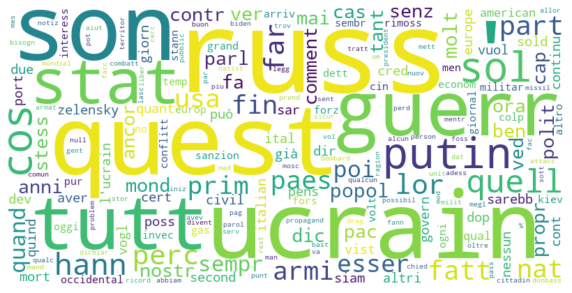

In [122]:
# Create a Word Cloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(
    width=800, height=400, background_color="white", contour_color="white"
)
wordcloud.generate_from_frequencies(frequencies=df_fdist.Frequency)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

The word cloud shows some words have the same origin, such as "quarto" and "quartos". Let's create a stemmed version of the word cloud

In [123]:
# Create a stemmed version of the words to normalize the Lexicon
# Import package
from nltk.stem import SnowballStemmer

In [124]:
# Check languages supported
print(" ".join(SnowballStemmer.languages))

arabic danish dutch english finnish french german hungarian italian norwegian porter portuguese romanian russian spanish swedish


In [125]:
# Do stemming
snowball = SnowballStemmer("italian")
# Create a new column for stemm words
processedReviews["StemmedWords"] = processedReviews["Words"].apply(stemming)

In [126]:
# Calculate frequency distributions of the stemmed words
fdist = FreqDist()
for review in processedReviews.StemmedWords:
    for term in review:
        fdist[term] += 1

# Create the sorted dataframe and sort it
df_fdist = pd.DataFrame.from_dict(fdist, orient="index")
df_fdist.columns = ["Frequency"]
df_fdist.index.name = "Term"
df_fdist = df_fdist.sort_values(by="Frequency", ascending=False)

In [127]:
# Remove the stopwords
df_fdist = df_fdist[~df_fdist.index.isin(stop_words)]

In [128]:
df_fdist.head()

,Frequency
Term,
russ,37649
quest,26462
ucrain,24069
son,23311
',21075


In [129]:
processedReviews["PreProcessedText"].head()

0    articolo di una supericialita'imbarazzante che...
1    e grazie a menti come queste che vivono nella ...
2    già fotografato il tizio quando parla di resid...
3    diciamo pure che quanto a corruzione l'ucraina...
4    oggi ci dicono che putin è debole e malato e c...
Name: PreProcessedText, dtype: object

(-0.5, 799.5, 399.5, -0.5)

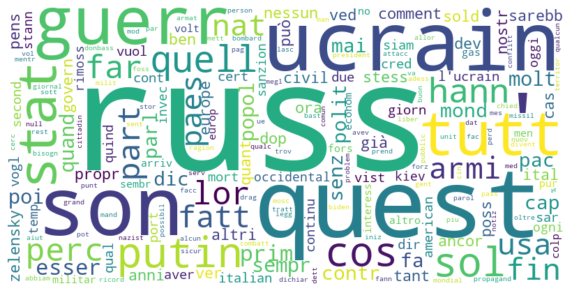

In [130]:
# Plot a new wordcloud with the stemmed words
wordcloud = WordCloud(
    width=800, height=400, background_color="white", contour_color="white"
)
wordcloud.generate_from_frequencies(frequencies=df_fdist.Frequency)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

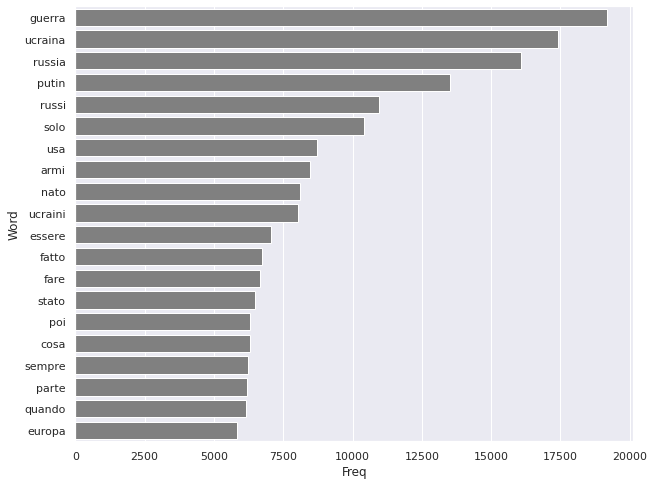

In [131]:
# PLOT top 20 most frequently occuring UNI-GRAMS
top_words = get_top_n_words(processedReviews["PreProcessedText"], n=20, nGrams=1)
top_df = pd.DataFrame(top_words)
top_df.columns = ["Word", "Freq"]
sns.set(rc={"figure.figsize": (10, 8)})
g = sns.barplot(data=top_df, x="Freq", y="Word", color="grey")

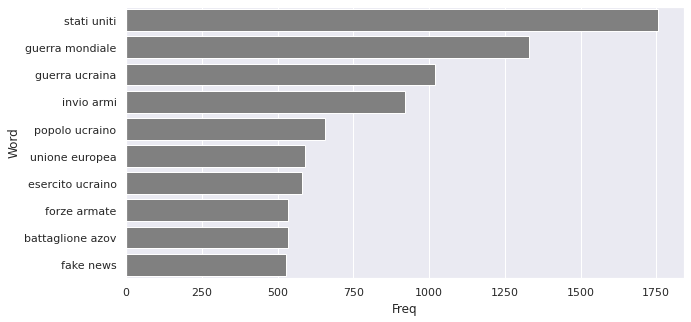

In [132]:
# PLOT top 20 most frequently occuring BI-GRAMS
top_words = get_top_n_words(processedReviews["PreProcessedText"], n=10, nGrams=2)
top_df = pd.DataFrame(top_words)
top_df.columns = ["Word", "Freq"]
sns.set(rc={"figure.figsize": (10, 5)})
g = sns.barplot(data=top_df, x="Freq", y="Word", color="grey")

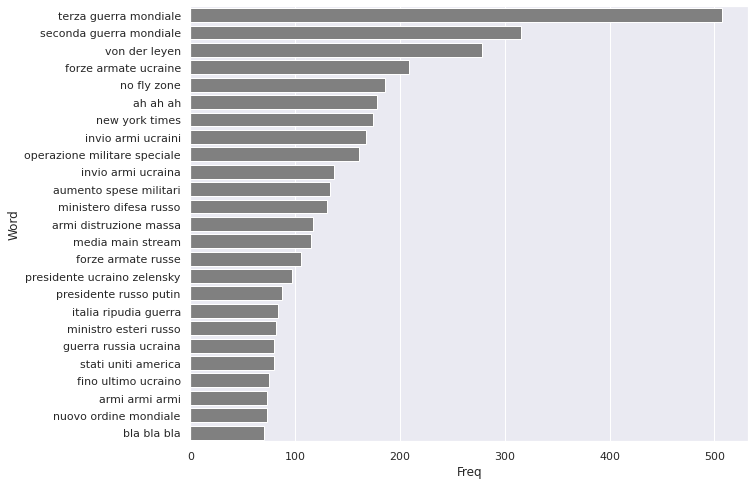

In [133]:
# PLOT top 20 most frequently occuring TRI-GRAMS
top_words = get_top_n_words(processedReviews["PreProcessedText"], n=25, nGrams=3)
top_df = pd.DataFrame(top_words)
top_df.columns = ["Word", "Freq"]
sns.set(rc={"figure.figsize": (10, 8)})
g = sns.barplot(data=top_df, x="Freq", y="Word", color="grey")

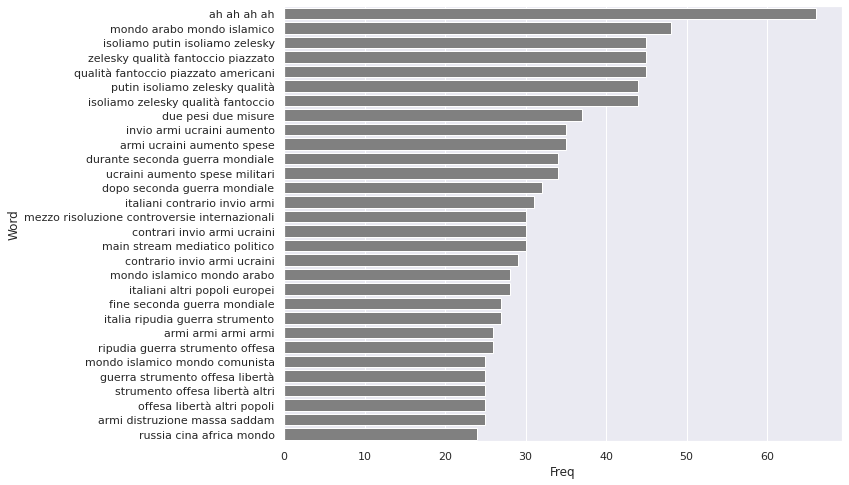

In [134]:
# PLOT top 20 most frequently occuring TRI-GRAMS
top_words = get_top_n_words(processedReviews["PreProcessedText"], n=30, nGrams=4)
top_df = pd.DataFrame(top_words)
top_df.columns = ["Word", "Freq"]
sns.set(rc={"figure.figsize": (10, 8)})
g = sns.barplot(data=top_df, x="Freq", y="Word", color="grey")

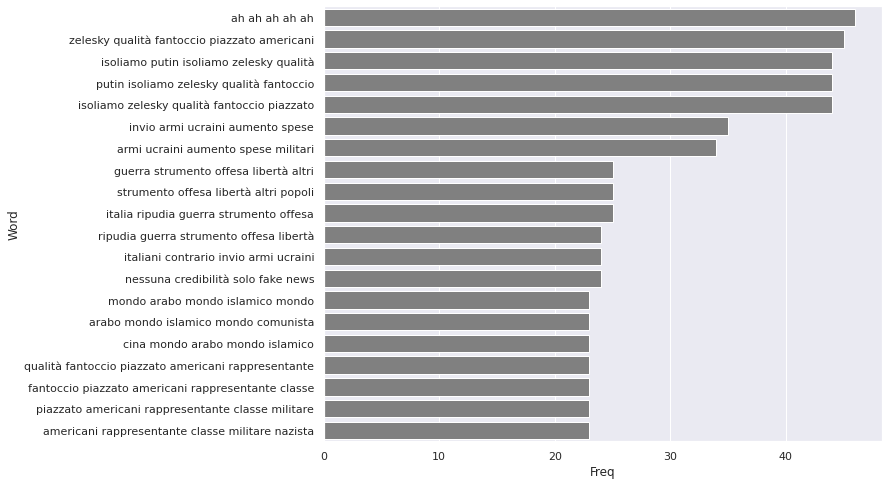

In [135]:
# PLOT top 20 most frequently occuring TRI-GRAMS
top_words = get_top_n_words(processedReviews["PreProcessedText"], n=20, nGrams=5)
top_df = pd.DataFrame(top_words)
top_df.columns = ["Word", "Freq"]
sns.set(rc={"figure.figsize": (10, 8)})
g = sns.barplot(data=top_df, x="Freq", y="Word", color="grey")

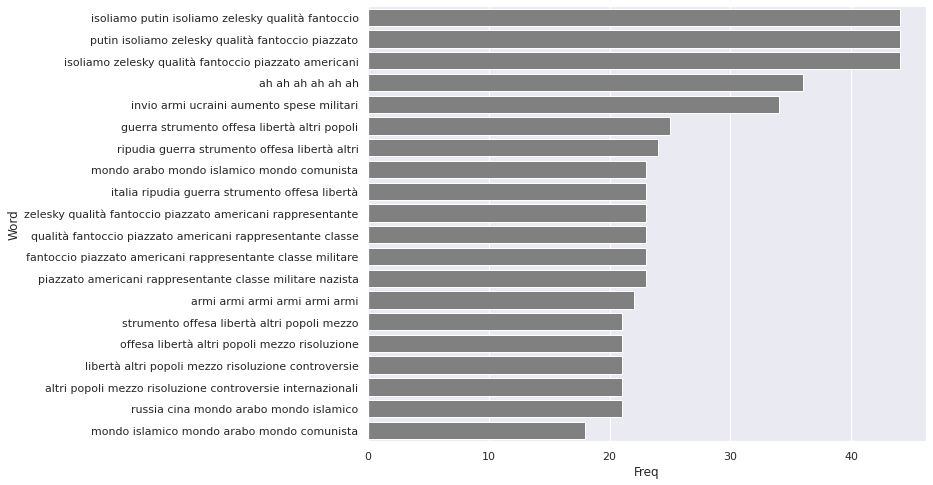

In [136]:
# PLOT top 20 most frequently occuring TRI-GRAMS
top_words = get_top_n_words(processedReviews["PreProcessedText"], n=20, nGrams=6)
top_df = pd.DataFrame(top_words)
top_df.columns = ["Word", "Freq"]
sns.set(rc={"figure.figsize": (10, 8)})
g = sns.barplot(data=top_df, x="Freq", y="Word", color="grey")